# 絵画の印象評価

In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm

import functions

SURVEY_PATH = Path("data", "survey")
tsv_file_path = SURVEY_PATH / "survey_results_05.tsv"

IMAGE_PATH = Path("data", "image")
SURVEY_PATH = Path("data", "survey")
CSV_OUTPUT_PATH = Path("data", "csv")
CSV_FILENAME = "results.csv"

## 好感度データの読み込み

In [2]:
impression_data = functions.load_impression_data_from_tsv(tsv_file_path)

## 画像のパスを取得

In [3]:
image_paths = functions.get_image_paths(IMAGE_PATH)

## CSVファイルを生成

In [4]:
functions.write_csv_output(image_paths, impression_data, output_path=CSV_OUTPUT_PATH, filename=CSV_FILENAME)

## 散布図を描画

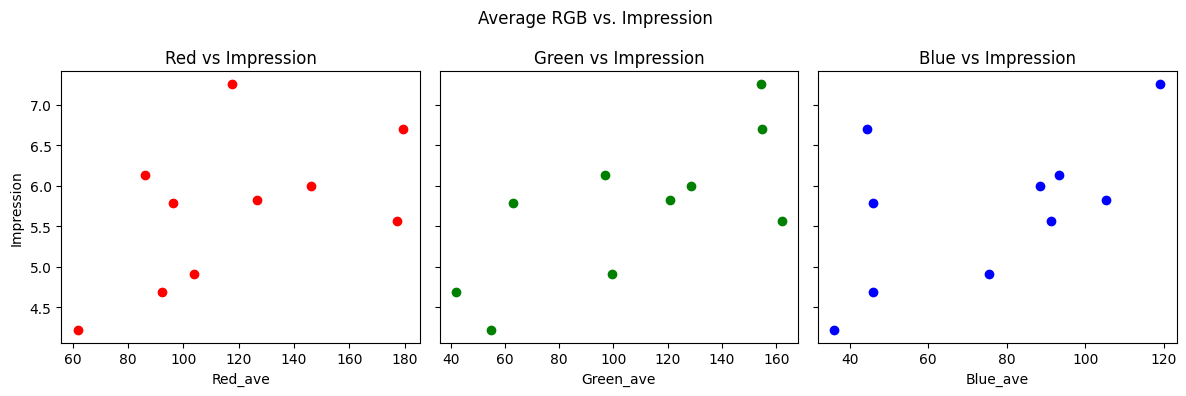

In [5]:
df = pd.read_csv(CSV_OUTPUT_PATH / CSV_FILENAME, delimiter="\t")

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 4), sharey=True)
fig.suptitle("Average RGB vs. Impression")

# Red_ave vs Impression
axes[0].scatter(df["Red_ave"], df["Impression"], color="red")
axes[0].set_title("Red vs Impression")
axes[0].set_xlabel("Red_ave")
axes[0].set_ylabel("Impression")
# Green_ave vs Impression
axes[1].scatter(df["Green_ave"], df["Impression"], color="green")
axes[1].set_title("Green vs Impression")
axes[1].set_xlabel("Green_ave")

# Blue_ave vs Impression
axes[2].scatter(df["Blue_ave"], df["Impression"], color="blue")
axes[2].set_title("Blue vs Impression")
axes[2].set_xlabel("Blue_ave")

plt.tight_layout()
plt.show()


## 重回帰分析を行う

1. データの読み込み

In [6]:
df = pd.read_csv(CSV_OUTPUT_PATH / CSV_FILENAME, delimiter="\t")

2. 説明変数(X)と目的変数(y)の作成

In [7]:
X = df[["Red_ave", "Green_ave", "Blue_ave"]]
y = df["Impression"]

3. statsmodelsのOLSに渡す前に、定数列(切片)を明示的に追加

In [8]:
X = sm.add_constant(X)

4. モデルを作成 & 学習

In [9]:
model = sm.OLS(y, X)
results = model.fit()

5. 決定係数(R^2)の取得

In [10]:
r2_score = results.rsquared

6. 回帰係数を取得

In [11]:
coefs = results.params

7. 回帰式と決定係数の表示

In [12]:
print("【回帰式】")
print(
    f"Impression = {coefs['const']:.4f}"
    f" + ({coefs['Red_ave']:.4f}) × Red_ave"
    f" + ({coefs['Green_ave']:.4f}) × Green_ave"
    f" + ({coefs['Blue_ave']:.4f}) × Blue_ave"
)
print("【決定係数(R^2)】:", round(r2_score, 4))

【回帰式】
Impression = 4.2310 + (-0.0058) × Red_ave + (0.0187) × Green_ave + (0.0021) × Blue_ave
【決定係数(R^2)】: 0.5579


8. 各回帰係数の有意検定

In [13]:
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:             Impression   R-squared:                       0.558
Model:                            OLS   Adj. R-squared:                  0.337
Method:                 Least Squares   F-statistic:                     2.523
Date:                Fri, 03 Jan 2025   Prob (F-statistic):              0.154
Time:                        18:37:48   Log-Likelihood:                -8.7163
No. Observations:                  10   AIC:                             25.43
Df Residuals:                       6   BIC:                             26.64
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.2310      1.101      3.841      0.0

c:\Users\go200\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_axis_nan_policy.py:418: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=10 observations were given.
  return hypotest_fun_in(*args, **kwds)


## 精度向上に向けて：標準偏差による重み付け

0. 好感度の平均・分散・weightを取得

In [14]:
variances_data = functions.load_image_variances_from_tsv(tsv_file_path,alpha=2.0)
weights = functions.extract_weights(variances_data)

1. データの読み込み

In [15]:
df = pd.read_csv(CSV_OUTPUT_PATH / CSV_FILENAME, delimiter="\t")

2. 説明変数(X)と目的変数(y)の作成

In [16]:
X = df[["Red_ave", "Green_ave", "Blue_ave"]]
y = df["Impression"]

3. statsmodelsのOLSに渡す前に、定数列(切片)を明示的に追加

In [17]:
X = sm.add_constant(X)

4. モデルを作成 & 学習

In [18]:
model = sm.WLS(endog=y, exog=X, weights=weights)
results = model.fit()

5. 決定係数(R^2)の取得

In [19]:
r2_score = results.rsquared

6. 回帰係数を取得

In [20]:
coefs = results.params

7. 回帰式と決定係数の表示

In [21]:
print("【回帰式】")
print(
    f"Impression = {coefs['const']:.4f}"
    f" + ({coefs['Red_ave']:.4f}) × Red_ave"
    f" + ({coefs['Green_ave']:.4f}) × Green_ave"
    f" + ({coefs['Blue_ave']:.4f}) × Blue_ave"
)
print("【決定係数(R^2)】:", round(r2_score, 4))

【回帰式】
Impression = 6.7540 + (-0.0306) × Red_ave + (0.0398) × Green_ave + (-0.0188) × Blue_ave
【決定係数(R^2)】: 0.7113


8. 各回帰係数の有意検定

In [22]:
print(results.summary())

                            WLS Regression Results                            
Dep. Variable:             Impression   R-squared:                       0.711
Model:                            WLS   Adj. R-squared:                  0.567
Method:                 Least Squares   F-statistic:                     4.927
Date:                Fri, 03 Jan 2025   Prob (F-statistic):             0.0466
Time:                        18:37:49   Log-Likelihood:                   -inf
No. Observations:                  10   AIC:                               inf
Df Residuals:                       6   BIC:                               inf
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.7540      1.118      6.043      0.0

c:\Users\go200\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_axis_nan_policy.py:418: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=10 observations were given.
  return hypotest_fun_in(*args, **kwds)
c:\Users\go200\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\regression\linear_model.py:806: RuntimeWarning: divide by zero encountered in log
  llf += 0.5 * np.sum(np.log(self.weights))
